In [0]:
!pip3 uninstall -y kaggle
!pip3 install --upgrade pip
!pip3 install kaggle==1.5.6
!kaggle -v

!mkdir /root/.kaggle
## Upload the kaggle.json file.
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip
!rm plant-seedlings-classification.zip sample_submission.csv

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os
import cv2
import math
import itertools


from glob import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# %tensorflow_version 1.x
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adadelta, SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Constants

In [5]:
TRAIN_DIRECTORY = "train"
TEST_DIRECTORY = "test"
IMG_HEIGHT = 70
IMG_WIDTH = 70
CATEGORIES = os.listdir(TRAIN_DIRECTORY)
num_classes = len(CATEGORIES)

lwr_hsv = (25,40,50)
upr_hsv = (75,255,255)

# Data Loading

In [9]:
path_to_all_files = TRAIN_DIRECTORY + '/*/*.png' 
files = glob(path_to_all_files)

trainImg = []
trainLabel = []
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    trainImg.append(cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

print(trainImg.shape)
print(trainLabel.shape)

(4750, 70, 70, 3)
(4750, 1)


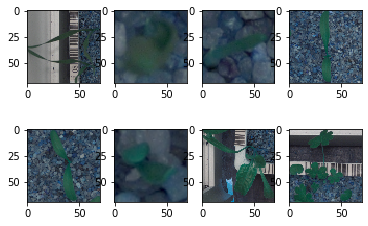

In [10]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i*100])

## Normalize Input & Categorize Labels

In [0]:
trainImg = trainImg / 255

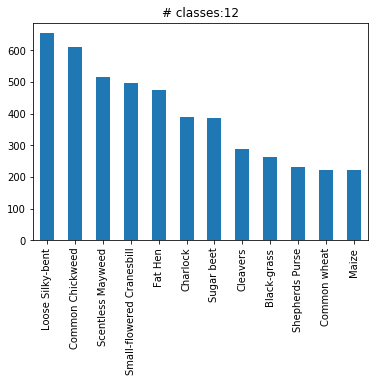

In [12]:
le = preprocessing.LabelEncoder()
encodeTrainLabels = le.fit_transform(trainLabel[0])
clearTrainLabel = to_categorical(encodeTrainLabels)

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar', title="# classes:" + str(clearTrainLabel.shape[1]))


# Model Definition

## Data splitting and Generator

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(trainImg, clearTrainLabel, 
                                                test_size=0.2, random_state=33, 
                                                stratify = clearTrainLabel)

In [0]:
# datagen = ImageDataGenerator(
#         rotation_range=180,  # randomly rotate images in the range
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally
#         height_shift_range=0.1,  # randomly shift images vertically 
#         horizontal_flip=True,  # randomly flip images horizontally
#         vertical_flip=True  # randomly flip images vertically
#     )  
# datagen.fit(X_train)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True, # randomly flip images
        )

datagen.fit(X_train)

## Model Architecture

In [6]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='same', input_shape=(IMG_WIDTH, IMG_WIDTH, 3)))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=64,kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(0.1))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Flatten())

model.add(Dropout(0.3))
model.add(Dense(128))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))


model.add(Dropout(0.3))
model.add(Dense(num_classes))
model.add(BatchNormalization(axis=-1))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

W1229 09:58:07.203855 139788627707712 deprecation.py:506] From /home/andrei/ml/env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


NameError: name 'num_classes' is not defined

In [0]:
# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="weight-cnn-nofilter.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')
filepath="weights-cnn-nofilter.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_acc', 
                                 verbose=1, save_best_only=False, mode='max')

BATCH_SIZE = 16

In [17]:
# fit model
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                           epochs=20,
                           validation_data=(X_valid, y_valid), 
                           steps_per_epoch=(10 * X_train.shape[0]) / BATCH_SIZE,
                           callbacks=[checkpoint, learning_rate_reduction, checkpoint_all])


Epoch 1/20
 950/2375 [===========>..................] - ETA: 2s - loss: 1.0678 - acc: 0.6411
Epoch 00001: val_acc improved from -inf to 0.64105, saving model to weight-cnn-nofilter.best_01-0.64.hdf5

Epoch 00001: saving model to weights-cnn-nofilter.last_auto4.hdf5
2375/2375 [==============================] - 170s 72ms/step - loss: 1.3847 - acc: 0.5428 - val_loss: 1.0697 - val_acc: 0.6411
Epoch 2/20
 950/2375 [===========>..................] - ETA: 2s - loss: 0.9082 - acc: 0.6800
Epoch 00002: val_acc improved from 0.64105 to 0.68000, saving model to weight-cnn-nofilter.best_02-0.68.hdf5

Epoch 00002: saving model to weights-cnn-nofilter.last_auto4.hdf5
2375/2375 [==============================] - 160s 67ms/step - loss: 0.8420 - acc: 0.7308 - val_loss: 0.9128 - val_acc: 0.6800
Epoch 3/20
 928/2375 [==========>...................] - ETA: 2s - loss: 0.6906 - acc: 0.7780
Epoch 00003: val_acc improved from 0.68000 to 0.77895, saving model to weight-cnn-nofilter.best_03-0.78.hdf5

Epoch 0000

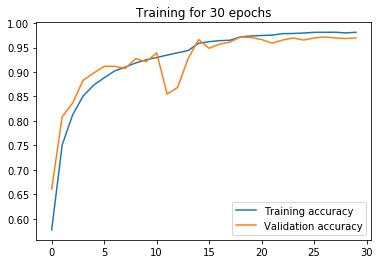

In [28]:
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.title('Training for ' +str(30)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.savefig('CNN_no_filter_history_accuracy.png', dpi=200)
plt.show()

In [0]:
import pickle
with open('CNN_no_filter_history.pkl', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)
    
model_json = model.to_json()
with open("CNN_no_filter_model.json", "w") as json_file:
    json_file.write(model_json)

In [23]:
import pickle

with open('../CNN-filter/CNN_filter_history.pkl', 'rb') as f:
    hist = pickle.load(f)

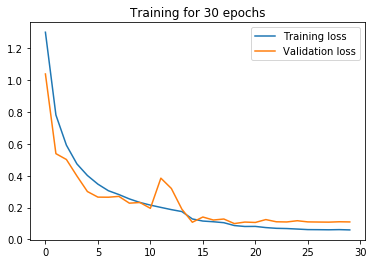

In [26]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('Training for ' +str(30)+ ' epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.savefig('CNN_filter_history_loss.png', dpi=200)
plt.show()

In [21]:
model.load_weights("weight-cnn-nofilter.best_20-0.96.hdf5")

print("Train accuracy", model.evaluate(X_train, y_train))  # Evaluate on train set
print("Validation accuracy", model.evaluate(X_valid, y_valid))  # Evaluate on test set

3800/3800 [==============================] - 5s 1ms/sample - loss: 0.0200 - acc: 0.9942
Train accuracy [0.020023323241131086, 0.99421054]
950/950 [==============================] - 1s 1ms/sample - loss: 0.1172 - acc: 0.9642
Validation accuracy [0.1172234825084084, 0.9642105]


# Confusion Matrix

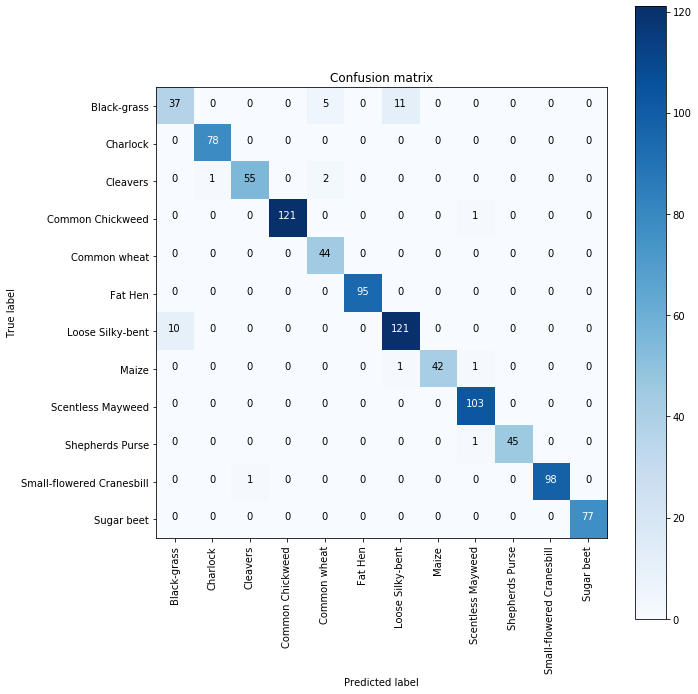

In [22]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('CNN_no_filter_confusion_matrix.png', dpi=200)

# Predict the values from the validation dataset
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_valid, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(y_true, y_pred_classes) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 


# Predicting on Test Set

(794, 70, 70, 3)


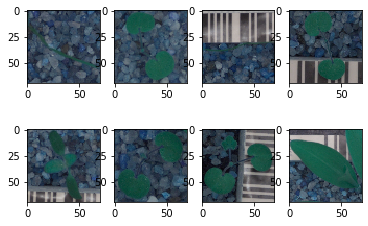

In [23]:
path =  TEST_DIRECTORY + '/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    testId.append(img.split('/')[-1])  # Images id's
    testImg.append(cv2.resize(cv2.imread(img), (IMG_WIDTH, IMG_HEIGHT)))
    j += 1

testImg = np.asarray(testImg)  # Train images set

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])
    
    
print(testImg.shape)

In [0]:
testImg = testImg / 255

In [0]:
pred = model.predict(testImg)

In [0]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("res.csv", index=False)

# Test score: 0.96095
